# Árvores de Decisão do Zero — Titanic

Implementações de ID3, C4.5 e CART aplicadas ao dataset Titanic.

## Seção 1 — Preparação dos dados

### Seção 1.1 — Titanic com discretização de contínuos

In [ ]:
import pandas as pd
import numpy as np


#estou usando o conjunto de treino tanto para gerar, quanto para testar a árvore.
base = pd.read_csv('./train.csv', sep =',', usecols=['Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'])


from sklearn.preprocessing import LabelEncoder
#para codificar todos os atributos para laberEncoder de uma única vez
#base_encoded = base.apply(LabelEncoder().fit_transform)
cols_label_encode = ['Embarked'] #único não numérico
base[cols_label_encode] = base[cols_label_encode].apply(LabelEncoder().fit_transform)

## PARA O ID3 - discretizar Age e Fare

#age em faixas fixas, sem labels
base['Age'] = pd.cut(base['Age'], bins=[0, 12, 18, 35, 60, 100], labels=False)

#fare em quartis
base['Fare'] = pd.qcut(base['Fare'], q=4, labels=False)

from sklearn.preprocessing import OneHotEncoder
cols_onehot_encode = ['Sex']
#oneHotEncoder
onehot = OneHotEncoder(sparse_output=False) #retorna um array denso

#oneHotEncoder apenas nas colunas categóricas
df_onehot = onehot.fit_transform(base[cols_onehot_encode])

#salvar novos nomes das colunas
nomes_das_colunas = onehot.get_feature_names_out(cols_onehot_encode)

#criar dataFrame com os dados codificados e as novas colunas
df_onehot = pd.DataFrame(df_onehot, columns=nomes_das_colunas)

#combinar as colunas codificadas com as colunas que não foram transformadas
base_encoded= pd.concat([df_onehot, base.drop(columns=cols_onehot_encode)], axis=1)




#selecionar a coluna survived
X_prev = base_encoded.drop(columns=['Survived'])
y_classe = base_encoded['Survived']

from sklearn.model_selection import train_test_split

#usando 20% da base com o stratify
X_treino, X_teste, y_treino, y_teste = train_test_split(X_prev, y_classe, test_size = 0.20, random_state = 42, stratify=y_classe)

#criar pickle
import pickle

with open('./titanic_Discret.pkl', mode = 'wb') as f:
  pickle.dump([X_treino, X_teste, y_treino, y_teste], f)

### Seção 1.2 — Titanic sem discretização de contínuos

In [ ]:
import pandas as pd
import numpy as np


#estou usando o conjunto de treino tanto para gerar, quanto para testar a árvore.
base = pd.read_csv('./train.csv', sep =',', usecols=['Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'])


from sklearn.preprocessing import LabelEncoder

#para codificar todos os atributos para laberEncoder de uma única vez
#base_encoded = base.apply(LabelEncoder().fit_transform)
cols_label_encode = ['Embarked'] #único não numérico
base[cols_label_encode] = base[cols_label_encode].apply(LabelEncoder().fit_transform)


from sklearn.preprocessing import OneHotEncoder
cols_onehot_encode = ['Sex']
#oneHotEncoder
onehot = OneHotEncoder(sparse_output=False) #retorna um array denso

#oneHotEncoder apenas nas colunas categóricas
df_onehot = onehot.fit_transform(base[cols_onehot_encode])

#salvar novos nomes das colunas
nomes_das_colunas = onehot.get_feature_names_out(cols_onehot_encode)

#criar dataFrame com os dados codificados e as novas colunas
df_onehot = pd.DataFrame(df_onehot, columns=nomes_das_colunas)

#combinar as colunas codificadas com as colunas que não foram transformadas
base_encoded= pd.concat([df_onehot, base.drop(columns=cols_onehot_encode)], axis=1)


#selecionar a coluna survived
X_prev = base_encoded.drop(columns=['Survived'])
y_classe = base_encoded['Survived']

from sklearn.model_selection import train_test_split

#usando 20% da base com o stratify
X_treino, X_teste, y_treino, y_teste = train_test_split(X_prev, y_classe, test_size = 0.20, random_state = 42, stratify=y_classe)

#criar pickle
import pickle

with open('./titanic_Continuo.pkl', mode = 'wb') as f:
  pickle.dump([X_treino, X_teste, y_treino, y_teste], f)

## Seção 2/3 — Implementações e Saídas

### 2.1 Utilidades comuns

- Cálculo de entropia, ganho de informação, razão de ganho, Gini

#### 2.1.1 (ID3) Cálculo de entropia e Ganho de informação

In [ ]:
def calcular_entropia(y):
    # quantas vezes cada classe aparece
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    # fórmula da entropia: -[somatório( p * log2(p))]
    entropia = 0.0
    for p in probs:
        if p > 0:
            entropia -= p * np.log2(p)
    return entropia


def ganho_informacao(X, y, atributo, corte):
    _, true_y, _, false_y = dividir_dados(X, y, atributo, corte) # obter só as parcelas verdadeiras e falsas da divisão
    p_true = len(true_y) / len(y) # parcela verdadeira do total
    p_false = len(false_y) / len(y) # parcela falsa do total
    ganho = calcular_entropia(y) - (p_true * calcular_entropia(true_y) + p_false * calcular_entropia(false_y)) # equação de ganho
    return ganho

#### 2.1.2 (C4.5) Razão de Ganho

In [ ]:
# calcular razão de ganho para atributos contínuos
def calcular_razaoGanho_continuo(X, y, atributo, limiar):
    X_left, y_left, X_right, y_right = dividir_dados_continuo(X, y, atributo, limiar) # dividir dados
    total = len(y) # número total de exemplos
    if len(y_left)==0 or len(y_right)==0: # se algum lado ficar vazio não há divisão válida
        return 0
    entropia_total = calcular_entropia(y) # entropia do conjunto original
    # entropia condicional ponderada pelos tamanhos dos subconjuntos
    entropia_cond = (len(y_left)/total)*calcular_entropia(y_left) + (len(y_right)/total)*calcular_entropia(y_right)
    ganho = entropia_total - entropia_cond # ganho de informação
    split_info = 0
    for subset in [y_left, y_right]:
        p = len(subset)/total # proporção de exemplos em cada subconjunto
        if p>0:
            split_info -= p*np.log2(p) # cálculo do split info
    return ganho/split_info if split_info>0 else 0 # retorna razão de ganho


# calcular razão de ganho para atributos categóricos
def calcular_razaoGanho_categorico(X, y, atributo):
    subsets = dividir_dados_categorico(X, y, atributo) # dividir dados em subconjuntos
    total = len(y) # número total de exemplos
    entropia_total = calcular_entropia(y) # entropia do conjunto original
    entropia_cond = 0
    split_info = 0
    for _, y_sub in subsets.values():
        p = len(y_sub)/total # proporção de exemplos no subconjunto
        entropia_cond += p*calcular_entropia(y_sub) # entropia condicional
        if p>0:
            split_info -= p*np.log2(p) # cálculo do split info
    ganho = entropia_total - entropia_cond # ganho de informação
    return ganho/split_info if split_info>0 else 0, subsets # retorna razão de ganho e subconjuntos

#### 2.1.3 (CART) Índice de Gini

In [ ]:

def calcular_gini(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1.0 - np.sum(probs ** 2)

def ganho_gini(X, y, atributo, corte):
    _, true_y, _, false_y = dividir_dados(X, y, atributo, corte)
    p_true = len(true_y) / len(y) if len(y) > 0 else 0
    p_false = len(false_y) / len(y) if len(y) > 0 else 0
    gini_total = calcular_gini(y)
    gini_split = p_true * calcular_gini(true_y) + p_false * calcular_gini(false_y)
    return gini_total - gini_split

### 2.2 ID3 e Saídas

- Critério: ganho de informação
- Usando Titanic discretizado
- Saídas com a árvore gerada e as regras obtidas

Amostra: [0. 1. 3. 2. 2. 0. 2. 2.] Real: 0 Previsto: 1
Amostra: [0. 1. 3. 3. 0. 1. 2. 2.] Real: 0 Previsto: 0
Amostra: [0. 1. 3. 2. 0. 0. 0. 0.] Real: 1 Previsto: 0
Amostra: [0. 1. 3. 3. 2. 0. 1. 2.] Real: 0 Previsto: 0
Amostra: [ 1.  0.  3. nan  1.  0.  2.  1.] Real: 1 Previsto: 1
Amostra: [1. 0. 3. 3. 1. 0. 2. 2.] Real: 1 Previsto: 0
Amostra: [1. 0. 2. 3. 0. 0. 1. 2.] Real: 1 Previsto: 1
Amostra: [0. 1. 1. 3. 0. 0. 2. 2.] Real: 0 Previsto: 1
Amostra: [0. 1. 1. 3. 1. 1. 3. 0.] Real: 0 Previsto: 1
Amostra: [0. 1. 2. 2. 1. 0. 2. 2.] Real: 0 Previsto: 0
Amostra: [ 0.  1.  3. nan  0.  0.  0.  1.] Real: 0 Previsto: 0
Amostra: [0. 1. 3. 1. 2. 0. 2. 2.] Real: 0 Previsto: 1
Amostra: [1. 0. 3. 2. 0. 0. 1. 2.] Real: 1 Previsto: 0
Amostra: [0. 1. 2. 2. 1. 1. 3. 0.] Real: 0 Previsto: 0
Amostra: [0. 1. 1. 2. 3. 2. 3. 2.] Real: 0 Previsto: 0
Amostra: [0. 1. 3. 2. 0. 0. 0. 1.] Real: 0 Previsto: 0
Amostra: [ 1.  0.  3. nan  3.  1.  2.  2.] Real: 0 Previsto: 0
Amostra: [ 0.  1.  3. nan  0.  0.  1.  2.

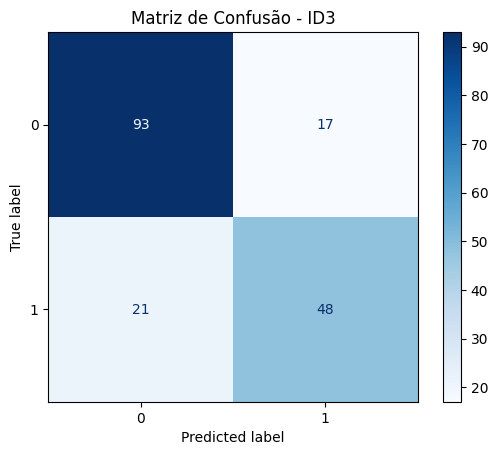

[Sex_female <= 0.0]
--> True:
   [Fare <= 1.0]
   --> True:
      [Age <= 0.0]
      --> True:
         Resposta -> 1
      --> False:
         [Fare <= 0.0]
         --> True:
            [Pclass <= 2.0]
            --> True:
               Resposta -> 0
            --> False:
               [Embarked <= 1.0]
               --> True:
                  [Age <= 2.0]
                  --> True:
                     [Embarked <= 0.0]
                     --> True:
                        [Age <= 1.0]
                        --> True:
                           Resposta -> 0
                        --> False:
                           Resposta -> 0
                     --> False:
                        Resposta -> 0
                  --> False:
                     [Age <= 4.0]
                     --> True:
                        Resposta -> 0
                     --> False:
                        [SibSp <= 0.0]
                        --> True:
                           [Embarked <=

In [ ]:
import numpy as np
from collections import Counter
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# classe nó
class Node:
    def __init__(self, atributo=None, value=None, resp=None, true_branch=None, false_branch=None):
        self.atributo = atributo         # índice do atributo usado para fazer a divisão nesse nó
        self.value = value               # valor de corte para o atributo
        self.resp = resp                 # resposta/classificação do nó folha
        self.true_branch = true_branch   # subárvore para <= valor
        self.false_branch = false_branch # subárvore para > valor



def calcular_entropia(y):
    # quantas vezes cada classe aparece
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    # fórmula da entropia: -[somatório( p * log2(p))]
    entropia = 0.0
    for p in probs:
        if p > 0:
            entropia -= p * np.log2(p)
    return entropia


def dividir_dados(X, y, atributo, corte):
    true_indices = [] # vetor de lista com os indices verdadeiros
    false_indices = [] # vetor de lista com os indices falsos
    for i in range(len(X)):
        # fazer o corte para cada atributo
        if X[i][atributo] <= corte:
            true_indices.append(i) #adicionar o indice do atributo true na lista
        else:
            false_indices.append(i) #adicionar o indice do atributo true

    true_X = X[true_indices]
    true_y = y[true_indices]
    false_X = X[false_indices]
    false_y = y[false_indices]

    return true_X, true_y, false_X, false_y # retornar tupla com todos os valores


# função para o ganho de informação
def ganho_informacao(X, y, atributo, corte):
    _, true_y, _, false_y = dividir_dados(X, y, atributo, corte) # obter só as parcelas verdadeiras e falsas da divisão
    p_true = len(true_y) / len(y) # parcela verdadeira do total
    p_false = len(false_y) / len(y) # parcela falsa do total
    ganho = calcular_entropia(y) - (p_true * calcular_entropia(true_y) + p_false * calcular_entropia(false_y)) # equação de ganho
    return ganho


# construção recursiva da árvore
def construir_arvore(X, y):
    # Caso base: todas as classes iguais
    if len(set(y)) == 1:
        return Node(resp=y[0])

    # variáveis "globais" que vão ser atualizadas de acordo com a construção da árvore
    melhor_ganho = 0
    melhor_atributo = None
    melhor_valor = None
    melhor_divisao = None

    # obter o número de atributos
    n_atributos = X.shape[1]

    # percorrer todos os atributos
    for atributo in range(n_atributos):
        # para cada atributo, obter todos as opções de valor dele
        valores_unicos = set(X[:, atributo])
        for valor in valores_unicos:
            # calcular o ganho para cada possível valor do atributo atual (se tiver ganhos iguais, então vai ser o primeiro que aparecer na matriz X)
            ganho = ganho_informacao(X, y, atributo, valor)
            if ganho > melhor_ganho:
                # se encontrar ganho melhor até agora então atualizar os valores globais
                melhor_ganho = ganho # ganho desse atributo
                melhor_atributo = atributo # guarda o indice do atributo para ser usado na classificação
                melhor_valor = valor # valor de corte
                melhor_divisao = dividir_dados(X, y, atributo, valor) # guardar os valores divididos

    # se foi encontrado um ganho continuar dividindo
    if melhor_ganho > 0:
        true_X, true_y, false_X, false_y = melhor_divisao
        true_branch = construir_arvore(true_X, true_y) #chamada recusriva para a classificação true
        false_branch = construir_arvore(false_X, false_y) #chamada recusriva para a classificação false
        new_no = Node(atributo=melhor_atributo, value=melhor_valor,true_branch=true_branch, false_branch=false_branch) #criar novo nó com essas informações
        return new_no # retornar o nó criado

    # condição de parada da recursão
    # se não houver ganho retorna nó folha
    classe_majoritaria = Counter(y).most_common(1)[0][0] # vai pegar a classe majoritária (se tiver mais "Sim" do que "Não", então a resposta será "Sim")
    new_no = Node(resp=classe_majoritaria) #retornar nó folha com a classe majoritária
    return new_no



# classificação/predição
def classificar(arvore, amostra):
    # percorrer a árvore com a amostra, até encontrar uma folha
    if arvore.resp is not None: #indica que é folha
        return arvore.resp
    if amostra[arvore.atributo] <= arvore.value:
        return classificar(arvore.true_branch, amostra)
    else:
        return classificar(arvore.false_branch, amostra)



# impressão recursiva da árvore
def imprimir_arvore(no, nomes_atributos, espacamento=""):
    if no.resp is not None:
        print(espacamento + "Resposta ->", no.resp)
        return
    nome = nomes_atributos[no.atributo] if no.atributo is not None else "?"
    print(espacamento + f"[{nome} <= {no.value}]")
    print(espacamento + "--> True:")
    imprimir_arvore(no.true_branch, nomes_atributos, espacamento + "   ")
    print(espacamento + "--> False:")
    imprimir_arvore(no.false_branch, nomes_atributos, espacamento + "   ")



# função pra mostrar as regras da árvore
def mostrar_regras(no, nomes_atributos, regra_atual=""):
    if no.resp is not None:
        # nó folha → imprime a regra completa com a classe
        print(regra_atual + f" ENTÃO Classe: {no.resp}")
        return
    
    nome = nomes_atributos[no.atributo] if no.atributo is not None else "?"
    
    # caminho True (<= valor)
    nova_regra_true = regra_atual + f"SE {nome} <= {no.value} "
    mostrar_regras(no.true_branch, nomes_atributos, nova_regra_true)
    
    # caminho False (> valor)
    nova_regra_false = regra_atual + f"SE {nome} > {no.value} "
    mostrar_regras(no.false_branch, nomes_atributos, nova_regra_false)


# exemplo com o titanic discretizado

with open('./titanic_Discret.pkl', 'rb') as f:
    X_treino, X_teste, y_treino, y_teste = pickle.load(f)

# guardar os nomes dos atributos antes de usar o numpy
nomes_atributos = list(X_treino.columns)

# converter para numpy arrays
X_treino = np.array(X_treino)
X_teste = np.array(X_teste)
y_treino = np.array(y_treino)
y_teste = np.array(y_teste)

arvore = construir_arvore(X_treino, y_treino)

# prever no conjunto de teste
y_pred = []
for i in range(len(X_teste)):
    pred = classificar(arvore, X_teste[i])
    y_pred.append(pred)
    print("Amostra:", X_teste[i], "Real:", y_teste[i], "Previsto:", pred)

# converter lista de previsões para numpy array
y_pred = np.array(y_pred)



# métricas
acuracia = accuracy_score(y_teste, y_pred)
precisao = precision_score(y_teste, y_pred, average='macro')  # 'macro' todos tem o mesmo peso
recall = recall_score(y_teste, y_pred, average='macro')
f1 = f1_score(y_teste, y_pred, average='macro')

print(f"Acurácia: {acuracia:.4f}")
print(f"Precisão: {precisao:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")




# matriz de Confusão
cm = confusion_matrix(y_teste, y_pred, labels=np.unique(y_teste))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_teste))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - ID3")
plt.show()


# imprimir a árvore
imprimir_arvore(arvore, nomes_atributos)


# imprimir as regras da árvore
print("\nRegras da árvore: ")
mostrar_regras(arvore, nomes_atributos)


### 2.3 C4.5 e Saídas

- Critério: razão de ganho (ganho normalizado)
- Usando Titanic com valores contínuos e nulos
- Handling de missing usando média (contínuos) e moda (categóricos)
- Saídas com a árvore gerada e as regras obtidas

Amostra: [ 0.    1.    3.   24.    2.    0.   24.15  2.  ] Real: 0 Previsto: 0
Amostra: [ 0.   1.   3.  44.   0.   1.  16.1  2. ] Real: 0 Previsto: 0
Amostra: [ 0.     1.     3.    22.     0.     0.     7.225  0.   ] Real: 1 Previsto: 0
Amostra: [ 0.      1.      3.     41.      2.      0.     14.1083  2.    ] Real: 0 Previsto: 0
Amostra: [ 1.   0.   3.   nan  1.   0.  15.5  1. ] Real: 1 Previsto: 1
Amostra: [ 1.   0.   3.  36.   1.   0.  17.4  2. ] Real: 1 Previsto: 0
Amostra: [ 1.  0.  2. 36.  0.  0. 13.  2.] Real: 1 Previsto: 1
Amostra: [ 0.    1.    1.   45.    0.    0.   26.55  2.  ] Real: 0 Previsto: 1
Amostra: [  0.       1.       1.      49.       1.       1.     110.8833   0.    ] Real: 0 Previsto: 1
Amostra: [ 0.  1.  2. 34.  1.  0. 26.  2.] Real: 0 Previsto: 0
Amostra: [0.   1.   3.    nan 0.   0.   7.75 1.  ] Real: 0 Previsto: 1
Amostra: [ 0.  1.  3. 16.  2.  0. 18.  2.] Real: 0 Previsto: 0
Amostra: [ 1.     0.     3.    27.     0.     0.     7.925  2.   ] Real: 1 Previsto:

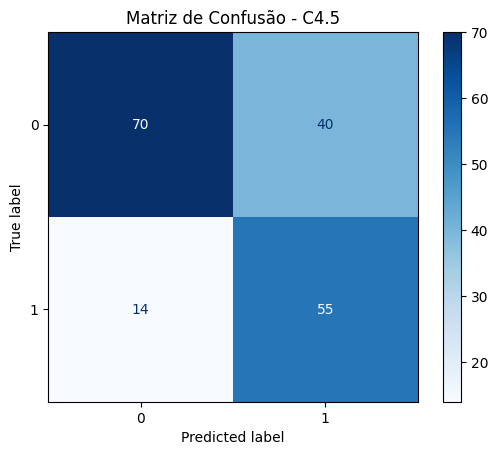

[Sex_female == 0.0]
   [Age <= 0.96]
   --> True:
      Resposta -> 1
   --> False:
      [Age <= 77.0]
      --> True:
         [Fare <= 387.6646]
         --> True:
            [Age <= 3.5]
            --> True:
               [SibSp == 0.0]
                  Resposta -> 1
               [SibSp == 1.0]
                  Resposta -> 1
               [SibSp == 2.0]
                  Resposta -> 1
               [SibSp == 3.0]
                  Resposta -> 0
               [SibSp == 4.0]
                  [Age == 1.0]
                     Resposta -> 0
                  [Age == 3.0]
                     Resposta -> 1
            --> False:
               [Fare <= 52.277100000000004]
               --> True:
                  [Fare <= 7.13335]
                  --> True:
                     Resposta -> 0
                  --> False:
                     [Fare <= 7.18335]
                     --> True:
                        Resposta -> 1
                     --> False:
                

In [ ]:
import numpy as np
import pickle
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# classe Nó
class Node:
    def __init__(self, atributo=None, value=None, resp=None, branches=None, true_branch=None, false_branch=None, tipo=None):
        self.atributo = atributo      # índice do atributo
        self.value = value            # limiar (contínuo) ou dict de ramos (categórico)
        self.resp = resp              # classe se for folha
        self.branches = branches      # dict {categoria: Node} se categórico
        self.true_branch = true_branch  # nó filho (<= limiar)
        self.false_branch = false_branch # nó filho (> limiar)
        self.tipo = tipo              # "cont" ou "cat" (contínu ou categórico)


# funções auxiliares
def calcular_entropia(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum([p*np.log2(p) for p in probs if p > 0])

#tratar nulos numéricos e categóricos
def tratar_nulos(X):
    X = X.copy()
    for j in range(X.shape[1]):
        col = X[:, j]

        # se for numérico → substitui NaN pela média
        if np.issubdtype(col.dtype, np.number):
            col = col.astype(float)
            mask = ~np.isnan(col)
            media = np.mean(col[mask]) if np.any(mask) else 0.0
            col[~mask] = media
            X[:, j] = col

        else:
            # se for categórico → substitui None ou np.nan pelo valor mais frequente
            col = col.astype(object)  # garante que tudo é tratado como objeto
            # filtra apenas valores válidos (não None, não nan)
            validos = [v for v in col if v is not None and v == v and v != ""]
            if len(validos) > 0:
                valores, counts = np.unique(validos, return_counts=True)
                mais_freq = valores[np.argmax(counts)]
                col = np.array([mais_freq if (v is None or v != v or v == "") else v for v in col], dtype=object)
                X[:, j] = col
    return X

# dividir dados para atributos contínuos
def dividir_dados_continuo(X, y, atributo, limiar):
    left_idx = X[:, atributo] <= limiar # índices onde o valor do atributo é menor ou igual ao limiar
    right_idx = X[:, atributo] > limiar # índices onde o valor do atributo é maior que o limiar
    return X[left_idx], y[left_idx], X[right_idx], y[right_idx] # retorna subconjuntos divididos


# dividir dados para atributos categóricos
def dividir_dados_categorico(X, y, atributo):
    valores = np.unique(X[:, atributo]) # obter valores únicos do atributo
    subsets = {} # dicionário para guardar subconjuntos
    for v in valores:
        idx = X[:, atributo] == v # índices onde o atributo é igual ao valor atual
        subsets[v] = (X[idx], y[idx]) # guardar subconjunto correspondente
    return subsets # retorna todos os subconjuntos


# calcular razão de ganho para atributos contínuos
def calcular_razaoGanho_continuo(X, y, atributo, limiar):
    X_left, y_left, X_right, y_right = dividir_dados_continuo(X, y, atributo, limiar) # dividir dados
    total = len(y) # número total de exemplos
    if len(y_left)==0 or len(y_right)==0: # se algum lado ficar vazio não há divisão válida
        return 0
    entropia_total = calcular_entropia(y) # entropia do conjunto original
    # entropia condicional ponderada pelos tamanhos dos subconjuntos
    entropia_cond = (len(y_left)/total)*calcular_entropia(y_left) + (len(y_right)/total)*calcular_entropia(y_right)
    ganho = entropia_total - entropia_cond # ganho de informação
    split_info = 0
    for subset in [y_left, y_right]:
        p = len(subset)/total # proporção de exemplos em cada subconjunto
        if p>0:
            split_info -= p*np.log2(p) # cálculo do split info
    return ganho/split_info if split_info>0 else 0 # retorna razão de ganho


# calcular razão de ganho para atributos categóricos
def calcular_razaoGanho_categorico(X, y, atributo):
    subsets = dividir_dados_categorico(X, y, atributo) # dividir dados em subconjuntos
    total = len(y) # número total de exemplos
    entropia_total = calcular_entropia(y) # entropia do conjunto original
    entropia_cond = 0
    split_info = 0
    for _, y_sub in subsets.values():
        p = len(y_sub)/total # proporção de exemplos no subconjunto
        entropia_cond += p*calcular_entropia(y_sub) # entropia condicional
        if p>0:
            split_info -= p*np.log2(p) # cálculo do split info
    ganho = entropia_total - entropia_cond # ganho de informação
    return ganho/split_info if split_info>0 else 0, subsets # retorna razão de ganho e subconjuntos


# detectar tipos de atributos automaticamente
def detectar_tipos(X, limite_cat=10):
    tipos = [] # lista para guardar o tipo de cada atributo
    for j in range(X.shape[1]):
        col = X[:, j] # coluna atual
        if np.issubdtype(col.dtype, np.number): # se for numérico
            if len(np.unique(col)) <= limite_cat: # se tiver poucos valores distintos
                tipos.append("cat") # trata como categórico
            else:
                tipos.append("cont") # trata como contínuo
        else:
            tipos.append("cat") # se não for numérico, é categórico
    return tipos # retorna lista com tipos de cada atributo


# construção recursiva da árvore
def construir_arvore(X, y, nomes_atributos, limite_cat=10):
    X = tratar_nulos(X) # tratar valores nulos antes de prosseguir

    # caso base: todas as classes iguais
    if len(set(y)) == 1:
        return Node(resp=y[0]) # retorna nó folha com a classe única

    # detectar se cada atributo é categórico ou contínuo
    tipos_atributos = detectar_tipos(X, limite_cat)

    # variáveis "globais" que vão ser atualizadas de acordo com a construção da árvore
    melhor_gain = 0
    melhor_atributo = None
    melhor_split_info = None
    tipo_split = None

    # percorrer todos os atributos
    for atributo in range(X.shape[1]):
        if tipos_atributos[atributo] == "cont":
            # ordenar valores únicos do atributo contínuo
            valores = np.unique(X[:, atributo])
            valores.sort()
            # testar limiares entre pares de valores consecutivos
            for i in range(len(valores)-1):
                limiar = (valores[i] + valores[i+1]) / 2
                gr = calcular_razaoGanho_continuo(X, y, atributo, limiar) # calcular razão de ganho
                if gr > melhor_gain:
                    # atualizar se encontrar melhor razão de ganho
                    melhor_gain = gr
                    melhor_atributo = atributo
                    melhor_split_info = limiar # guardar limiar de corte
                    tipo_split = "cont"
        else:
            # calcular razão de ganho para atributos categóricos
            gr, subsets = calcular_razaoGanho_categorico(X, y, atributo)
            if gr > melhor_gain:
                melhor_gain = gr
                melhor_atributo = atributo
                melhor_split_info = subsets # guardar subconjuntos resultantes
                tipo_split = "cat"

    # condição de parada: se não houver ganho retorna nó folha com classe majoritária
    if melhor_gain == 0:
        return Node(resp=Counter(y).most_common(1)[0][0])

    # se o melhor atributo for contínuo
    if tipo_split == "cont":
        limiar = melhor_split_info
        X_left, y_left, X_right, y_right = dividir_dados_continuo(X, y, melhor_atributo, limiar)
        return Node(
            atributo=melhor_atributo,
            value=limiar, # valor de corte
            tipo="cont", # marca como contínuo
            true_branch=construir_arvore(X_left, y_left, nomes_atributos, limite_cat), # chamada recursiva para <= limiar
            false_branch=construir_arvore(X_right, y_right, nomes_atributos, limite_cat) # chamada recursiva para > limiar
        )
    else:
        # se o melhor atributo for categórico
        branches = {}
        for valor, (X_sub, y_sub) in melhor_split_info.items():
            branches[valor] = construir_arvore(X_sub, y_sub, nomes_atributos, limite_cat) # chamada recursiva para cada categoria
        return Node(atributo=melhor_atributo, branches=branches, tipo="cat") # criar nó com múltiplos ramos
    


# classificação/predição com nós do tipo continuo e categórico
def classificar(no, amostra):
    if no.resp is not None:
        return no.resp
    if no.tipo == "cont":
        if amostra[no.atributo] <= no.value:
            return classificar(no.true_branch, amostra)
        else:
            return classificar(no.false_branch, amostra)
    else:
        valor = amostra[no.atributo]
        if valor in no.branches:
            return classificar(no.branches[valor], amostra)
        else:
            #retorna a classe majoritária do nó
            classes = []
            for branch in no.branches.values():
                c = classificar(branch, amostra)
                classes.append(c)

            contagem = Counter(classes)
            mais_comum = contagem.most_common(1)[0][0]
            return mais_comum



# impressão recursiva da árvore
def imprimir_arvore(no, nomes_atributos, espacamento=""):
    if no.resp is not None:
        print(espacamento + "Resposta ->", no.resp)
        return
    nome = nomes_atributos[no.atributo]
    if no.tipo == "cont":
        print(espacamento + f"[{nome} <= {no.value}]")
        print(espacamento + "--> True:")
        imprimir_arvore(no.true_branch, nomes_atributos, espacamento + "   ")
        print(espacamento + "--> False:")
        imprimir_arvore(no.false_branch, nomes_atributos, espacamento + "   ")
    else:
        for valor, branch in no.branches.items():
            print(espacamento + f"[{nome} == {valor}]")
            imprimir_arvore(branch, nomes_atributos, espacamento + "   ")



# função pra mostrar as regras da árvore
def mostrar_regras(no, nomes_atributos, regra_atual=""):
    if no.resp is not None:
        print(regra_atual + f" ENTÃO Classe: {no.resp}")
        return
    nome = nomes_atributos[no.atributo]
    if no.tipo == "cont":
        mostrar_regras(no.true_branch, nomes_atributos, regra_atual + f"SE {nome} <= {no.value} ")
        mostrar_regras(no.false_branch, nomes_atributos, regra_atual + f"SE {nome} > {no.value} ")
    else:
        for valor, branch in no.branches.items():
            mostrar_regras(branch, nomes_atributos, regra_atual + f"SE {nome} == {valor} ")



# exemplo com o tinanic com valores contínuos e missing
with open('./titanic_Continuo.pkl', 'rb') as f:
    X_treino, X_teste, y_treino, y_teste = pickle.load(f)

# nomes dos atributos
nomes_atributos = list(X_treino.columns)

# converter para numpy
X_treino = np.array(X_treino)
X_teste = np.array(X_teste)
y_treino = np.array(y_treino)
y_teste = np.array(y_teste)

# construir árvore com detecção automática de tipos
arvore = construir_arvore(X_treino, y_treino, nomes_atributos)

# prever no conjunto de teste
y_pred = []
for i in range(len(X_teste)):
    pred = classificar(arvore, X_teste[i])
    y_pred.append(pred)
    print("Amostra:", X_teste[i], "Real:", y_teste[i], "Previsto:", pred)

y_pred = np.array(y_pred)

# métricas
acuracia = accuracy_score(y_teste, y_pred)
precisao = precision_score(y_teste, y_pred, average='macro')
recall = recall_score(y_teste, y_pred, average='macro')
f1 = f1_score(y_teste, y_pred, average='macro')

print(f"Acurácia: {acuracia:.4f}")
print(f"Precisão: {precisao:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# matriz de confusão
cm = confusion_matrix(y_teste, y_pred, labels=np.unique(y_teste))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_teste))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - C4.5")
plt.show()


# imprimir a árvore
imprimir_arvore(arvore, nomes_atributos)


# imprimir as regras
print("\nRegras da árvore: ")
mostrar_regras(arvore, nomes_atributos)


### 2.4 CART e Saídas

- Critério: Gini
- Splits binários sempre
- Usando Titanic com valores Contínuos e nulos
- Saídas com a árvore gerada e as regras obtidas

Amostra: [ 0.    1.    3.   24.    2.    0.   24.15  2.  ] Real: 0 Previsto: 0
Amostra: [ 0.   1.   3.  44.   0.   1.  16.1  2. ] Real: 0 Previsto: 0
Amostra: [ 0.     1.     3.    22.     0.     0.     7.225  0.   ] Real: 1 Previsto: 0
Amostra: [ 0.      1.      3.     41.      2.      0.     14.1083  2.    ] Real: 0 Previsto: 0
Amostra: [ 1.   0.   3.   nan  1.   0.  15.5  1. ] Real: 1 Previsto: 0
Amostra: [ 1.   0.   3.  36.   1.   0.  17.4  2. ] Real: 1 Previsto: 0
Amostra: [ 1.  0.  2. 36.  0.  0. 13.  2.] Real: 1 Previsto: 1
Amostra: [ 0.    1.    1.   45.    0.    0.   26.55  2.  ] Real: 0 Previsto: 1
Amostra: [  0.       1.       1.      49.       1.       1.     110.8833   0.    ] Real: 0 Previsto: 0
Amostra: [ 0.  1.  2. 34.  1.  0. 26.  2.] Real: 0 Previsto: 0
Amostra: [0.   1.   3.    nan 0.   0.   7.75 1.  ] Real: 0 Previsto: 0
Amostra: [ 0.  1.  3. 16.  2.  0. 18.  2.] Real: 0 Previsto: 0
Amostra: [ 1.     0.     3.    27.     0.     0.     7.925  2.   ] Real: 1 Previsto:

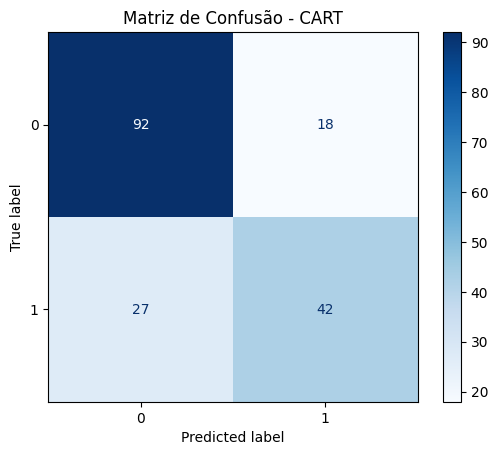

[Sex_female <= 0.0]
--> True:
   [Age <= 3.0]
   --> True:
      [SibSp <= 2.0]
      --> True:
         Resposta -> 1
      --> False:
         [Age <= 2.0]
         --> True:
            Resposta -> 0
         --> False:
            Resposta -> 1
   --> False:
      [Pclass <= 1.0]
      --> True:
         [Fare <= 26.0]
         --> True:
            Resposta -> 0
         --> False:
            [Fare <= 30.5]
            --> True:
               [Age <= 52.0]
               --> True:
                  [Fare <= 26.55]
                  --> True:
                     [Age <= 29.807686956521735]
                     --> True:
                        [Age <= 28.0]
                        --> True:
                           Resposta -> 1
                        --> False:
                           Resposta -> 0
                     --> False:
                        Resposta -> 1
                  --> False:
                     [Fare <= 28.5]
                     --> True:
          

In [4]:
import numpy as np
import pickle
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# classe nó da árvore
class Node:
    def __init__(self, atributo=None, value=None, resp=None, true_branch=None, false_branch=None):
        self.atributo = atributo         # índice do atributo usado para fazer a divisão nesse nó
        self.value = value               # valor de corte para o atributo
        self.resp = resp                 # resposta/classificação do nó folha
        self.true_branch = true_branch   # subárvore para <= valor
        self.false_branch = false_branch # subárvore para > valor


# funções auxiliares
def tratar_nulos(X):
    X = X.copy().astype(float)  # cria uma cópia da matriz e garante que os valores sejam float
    linhas, colunas = X.shape
    for j in range(colunas):
        soma, cont = 0.0, 0
        # percorre todas os valores
        for i in range(linhas):
            if not np.isnan(X[i][j]):  # se não for nulo
                soma += X[i][j]       # soma os valores
                cont += 1             # conta quantos valores válidos existem
        media = soma / cont if cont > 0 else 0.0  # calcula a média da coluna (se não tiver valores válidos, usa 0)
        for i in range(linhas):
            if np.isnan(X[i][j]):     # substitui valores nulos pela média da coluna
                X[i][j] = media
    return X


def dividir_dados(X, y, atributo, corte):
    true_indices, false_indices = [], []
    for i in range(len(X)):
        if X[i][atributo] <= corte:   # se o valor do atributo for menor ou igual ao corte
            true_indices.append(i)    # vai para o ramo verdadeiro
        else:
            false_indices.append(i)   # caso contrário, vai para o ramo falso
    return X[true_indices], y[true_indices], X[false_indices], y[false_indices]


def calcular_gini(y):
    _, counts = np.unique(y, return_counts=True)  # conta quantas vezes cada classe aparece
    probs = counts / len(y)                       # calcula a proporção de cada classe
    return 1.0 - np.sum(probs ** 2)               # fórmula do índice de gini


def ganho_gini(X, y, atributo, corte):
    _, true_y, _, false_y = dividir_dados(X, y, atributo, corte)  # divide os dados pelo corte
    p_true = len(true_y) / len(y) if len(y) > 0 else 0            # proporção do ramo verdadeiro
    p_false = len(false_y) / len(y) if len(y) > 0 else 0          # proporção do ramo falso
    gini_total = calcular_gini(y)                                 # gini do conjunto original
    gini_split = p_true * calcular_gini(true_y) + p_false * calcular_gini(false_y)
    return gini_total - gini_split                                # ganho de gini


# construção recursiva da árvore CART
def construir_arvore_CART(X, y):
    X = tratar_nulos(X)  # primeiro trata valores nulos substituindo pela média

    # caso base: todas as classes iguais
    if len(set(y)) == 1:
        return Node(resp=y[0])  # retorna nó folha com a classe única

    # variáveis "globais" que vão ser atualizadas de acordo com a construção da árvore
    melhor_ganho, melhor_atributo, melhor_valor, melhor_divisao = 0, None, None, None
    n_atributos = X.shape[1]  # número de atributos

    # percorre todos os atributos
    for atributo in range(n_atributos):
        valores_unicos = np.unique(X[:, atributo])  # pega todos os valores únicos do atributo
        for valor in valores_unicos:
            ganho = ganho_gini(X, y, atributo, valor)  # calcula o ganho de gini para esse valor
            if ganho > melhor_ganho:
                # se encontrar ganho melhor até agora então atualizar os valores globais
                melhor_ganho = ganho       # guarda o ganho
                melhor_atributo = atributo # guarda o índice do atributo
                melhor_valor = valor       # guarda o valor de corte
                melhor_divisao = dividir_dados(X, y, atributo, valor) # guarda a divisão feita

    # se foi encontrado um ganho continuar dividindo
    if melhor_ganho > 0:
        true_X, true_y, false_X, false_y = melhor_divisao
        true_branch = construir_arvore_CART(true_X, true_y)    # chamada recursiva para o ramo verdadeiro
        false_branch = construir_arvore_CART(false_X, false_y) # chamada recursiva para o ramo falso
        return Node(atributo=melhor_atributo, value=melhor_valor,
                    true_branch=true_branch, false_branch=false_branch)

    # condição de parada da recursão
    # se não houver ganho retorna nó folha
    classe_majoritaria = Counter(y).most_common(1)[0][0]  # pega a classe majoritária
    return Node(resp=classe_majoritaria)                  # retorna nó folha com a classe majoritária




# classificação/predição
def classificar(arvore, amostra):
    if arvore.resp is not None:
        return arvore.resp
    if amostra[arvore.atributo] <= arvore.value:
        return classificar(arvore.true_branch, amostra)
    else:
        return classificar(arvore.false_branch, amostra)

# ---------------------------
# Impressão da árvore (com nomes de atributos)
# ---------------------------
def imprimir_arvore(no, nomes_atributos, espacamento=""):
    if no.resp is not None:
        print(espacamento + "Resposta ->", no.resp)
        return
    nome = nomes_atributos[no.atributo] if no.atributo is not None else "?"
    print(espacamento + f"[{nome} <= {no.value}]")
    print(espacamento + "--> True:")
    imprimir_arvore(no.true_branch, nomes_atributos, espacamento + "   ")
    print(espacamento + "--> False:")
    imprimir_arvore(no.false_branch, nomes_atributos, espacamento + "   ")

# ---------------------------
# Função para mostrar as regras da árvore
# ---------------------------
def mostrar_regras(no, nomes_atributos, regra_atual=""):
    if no.resp is not None:
        # Nó folha → imprime a regra completa com a classe
        print(regra_atual + f" ENTÃO Classe: {no.resp}")
        return
    
    nome = nomes_atributos[no.atributo] if no.atributo is not None else "?"
    
    # Caminho True (<= valor)
    nova_regra_true = regra_atual + f"SE {nome} <= {no.value} "
    mostrar_regras(no.true_branch, nomes_atributos, nova_regra_true)
    
    # Caminho False (> valor)
    nova_regra_false = regra_atual + f"SE {nome} > {no.value} "
    mostrar_regras(no.false_branch, nomes_atributos, nova_regra_false)





# exemplo com o tinanic com valores contínuos e missing
with open('./titanic_Continuo.pkl', 'rb') as f:
    X_treino, X_teste, y_treino, y_teste = pickle.load(f)

# guardar os nomes dos atributos antes de usar o numpy
nomes_atributos = list(X_treino.columns)

# converter para numpy
X_treino_np = X_treino.values
X_teste_np = X_teste.values
y_treino = np.array(y_treino)
y_teste = np.array(y_teste)

# construir árvore
arvore = construir_arvore_CART(X_treino_np, y_treino)

# prever no conjunto de teste
y_pred = []
for i in range(len(X_teste_np)):
    pred = classificar(arvore, X_teste_np[i])
    y_pred.append(pred)
    print("Amostra:", X_teste_np[i], "Real:", y_teste[i], "Previsto:", pred)

y_pred = np.array(y_pred)

# métricas
acuracia = accuracy_score(y_teste, y_pred)
precisao = precision_score(y_teste, y_pred, average='macro')
recall = recall_score(y_teste, y_pred, average='macro')
f1 = f1_score(y_teste, y_pred, average='macro')

print(f"Acurácia: {acuracia:.4f}")
print(f"Precisão: {precisao:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# matriz de Confusão
cm = confusion_matrix(y_teste, y_pred, labels=np.unique(y_teste))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_teste))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - CART")
plt.show()

# impressão da árvore com nomes
imprimir_arvore(arvore, nomes_atributos)

# imprimir as regras da árvore
print("\nRegras da árvore: ")
mostrar_regras(arvore, nomes_atributos)

